In [ ]:
# Yiming Guo 07/14/2024
"""
./bin/ycsb run basic -p recordcount=100 -p operationcount=500000 -p workload=site.ycsb.workloads.CoreWorkload -p requestdistribution=hotspot -p hotspotdatafraction=0.2 -p hotspotopnfraction=0.8 -p readproportion=1.0 -p insertorder=ordered -p updateproportion=0 -s > data/tracea_load.txt
"""
import os
import subprocess
import time
import csv
import pandas as pd
import numpy as np
from collections import Counter
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# import torch

# torch.cuda.empty_cache()
# print("CUDA 是否可用:", torch.cuda.is_available())
# print("当前 CUDA 设备数量:", torch.cuda.device_count())
# print("当前 CUDA 设备名称:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "无")
import torch

# 检查 CUDA 可用性
print("CUDA 是否可用:", torch.cuda.is_available())
print("当前 CUDA 设备数量:", torch.cuda.device_count())

# 如果 CUDA 不可用，尝试找出原因
if not torch.cuda.is_available():
    print("\nCUDA 不可用的可能原因:")
    
    # 检查是否安装了 GPU 版本的 PyTorch
    print("PyTorch 版本:", torch.__version__)
    
    # 检查 CUDA 是否在系统上可用
    try:
        import subprocess
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if result.returncode != 0:
            print("1. 系统中没有 NVIDIA GPU 或 NVIDIA 驱动程序未正确安装")
        else:
            print("1. 系统中有 NVIDIA GPU，但 PyTorch 可能未编译为 GPU 版本")
    except:
        print("1. 无法执行 nvidia-smi 命令")
    
    # 检查是否安装了正确版本的 PyTorch
    print("2. 您可能安装了 CPU 版本的 PyTorch，而不是 GPU 版本")
    
    # 建议的解决方案
    print("\n解决方案:")
    print("a. 确保系统中有 NVIDIA GPU")
    print("b. 安装 NVIDIA 驱动程序 (使用 nvidia-smi 检查)")
    print("c. 安装 CUDA 工具包")
    print("d. 安装与您 CUDA 版本匹配的 GPU 版本 PyTorch:")
    print("   访问 https://pytorch.org/get-started/locally/ 获取正确的安装命令")
    
    # 示例安装命令
    print("\n例如，对于 CUDA 11.7:")
    print("pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117")
else:
    print("当前 CUDA 设备名称:", torch.cuda.get_device_name(0))

In [ ]:


YCSB_PATH = "/home/ming/桌面/Lion/YCSB"  # YCSB安装路径
OUTPUT_FILE = "/home/ming/桌面/Lion/ycsb_hotspot_result.txt"  # 原始结果输出文件
PROCESSED_FILE = "/home/ming/桌面/Lion/lstm_dataset.csv"  # 处理后的数据集文件
LOG_FILE = "/home/ming/桌面/Lion/query_log.txt"  # 详细查询日志文件
MODEL_PATH = "/home/ming/桌面/Lion/hotspot_predictor.pth"  # 模型保存路径
RECORD_COUNT = 100  # 数据集大小
OPERATION_COUNT = 500000  # 查询操作数量
HOTSPOT_FRACTION = 0.2  # 20%的热点键
HOTSPOT_OPS_FRACTION = 0.8  # 80%的操作访问热点
WINDOW_SIZE_MS = 100  # 时间窗口大小(毫秒)
SEQUENCE_LENGTH = 10  # 输入序列长度(时间窗口数)
KEYS_PER_WINDOW = 20  # 每个时间窗口跟踪的热键数量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


In [ ]:
import subprocess
import os

def run_ycsb_command():
    ycsb_dir = "/home/ming/桌面/PLIN-N /PLIN-N/YCSB"
    original_dir = os.getcwd()
    os.chdir(ycsb_dir)

    # # load
    # load_command = [
    #     "./bin/ycsb", "load", "basic",
    #     "-p", "recordcount=10000000",    # total 10000000 10000000
    #     "-p", "operationcount=50000000",
    #     "-p", "workload=site.ycsb.workloads.CoreWorkload",
    #     "-p", "requestdistribution=zipfian",
    #     # "-p", "hotspotdatafraction=0.2",
    #     # "-p", "hotspotopnfraction=0.8",
    #     "-p", "readproportion=1.0",
    #     "-p", "insertorder=ordered",
    #     "-p", "updateproportion=0",
    #     "-p","readallfields=true",
    #     "-s"
    # ]
    
    # with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_load.txt", "w") as f:
    #     subprocess.run(load_command, stdout=f, stderr=subprocess.PIPE, text=True)

    # # run
    # run_command = [
    #     "./bin/ycsb", "run", "basic",
    #     "-p", "recordcount=10000000",  
    #     "-p", "operationcount=50000000", 
    #     "-p", "workload=site.ycsb.workloads.CoreWorkload",
    #     "-p", "requestdistribution=zipfian",
    #     # "-p", "hotspotdatafraction=0.2",
    #     # "-p", "hotspotopnfraction=0.8",
    #     "-p", "readproportion=1.0",
    #     "-p", "insertorder=ordered",
    #     "-p", "updateproportion=0",
    #     "-p","readallfields=true",
    #     "-s"
    # ]
    # f.close()
    # load
    load_command = [
        "./bin/ycsb", "load", "basic",
        "-p", "recordcount=1000000",    # total 10000000
        "-p", "operationcount=25000000",
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_load.txt", "w") as f:
        subprocess.run(load_command, stdout=f, stderr=subprocess.PIPE, text=True)

    # run
    run_command = [
        "./bin/ycsb", "run", "basic",
        "-p", "recordcount=1000000",  
        "-p", "operationcount=25000000", 
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    f.close()
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_run.txt", "w") as f1:
        subprocess.run(run_command, stdout=f1, stderr=subprocess.PIPE, text=True)

    os.chdir(original_dir)

run_ycsb_command()

In [ ]:
import subprocess
import os

def run_ycsb_command():
    ycsb_dir = "/home/ming/桌面/PLIN-N /PLIN-N/YCSB"
    original_dir = os.getcwd()
    os.chdir(ycsb_dir)

    load_command = [
        "./bin/ycsb", "load", "basic",
        "-p", "recordcount=1000000",    # total 10000000
        "-p", "operationcount=25000000",
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_load.txt", "w") as f:
        subprocess.run(load_command, stdout=f, stderr=subprocess.PIPE, text=True)

    # run
    run_command = [
        "./bin/ycsb", "run", "basic",
        "-p", "recordcount=1000000",  
        "-p", "operationcount=25000000", 
        "-p", "workload=site.ycsb.workloads.CoreWorkload",
        "-p", "requestdistribution=zipfian",
        "-p", "readproportion=1.0",
        "-p", "insertorder=ordered",
        "-p", "updateproportion=0",
        "-p","readallfields=true",
        "-s"
    ]
    f.close()
    
    with open("/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_run.txt", "w") as f1:
        subprocess.run(run_command, stdout=f1, stderr=subprocess.PIPE, text=True)

    os.chdir(original_dir)

run_ycsb_command()

In [ ]:
import re
import sys
from collections import defaultdict

input_file = "/home/ming/桌面/PLIN-N /PLIN-N/build/tracea_run.txt"
output_file = "/home/ming/桌面/PLIN-N /PLIN-N/build/command_plus.txt"
output_file_summary = "/home/ming/桌面/PLIN-N /PLIN-N/build/processed_key_summary.txt"

def extract_keys_from_ycsb_log(input_file, output_file):
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            log_content = f.readlines()
        
        key_counts = defaultdict(int)
        total_keys = 0
        keys = []
         
        for line in log_content:
            match = None
            if 'READ usertable' in line:
                match = re.search(r'READ usertable (\w+)', line)
            elif 'UPDATE usertable' in line:
                match = re.search(r'UPDATE usertable (\w+)', line)
            elif 'DELETE usertable' in line:
                match = re.search(r'DELETE usertable (\w+)', line)
            
            if match:
                key = match.group(1)
                keys.append("find " + match.group(1)[4:])
                if key.startswith("user"):
                    key = key[4:]
                key_counts[key] += 1
                total_keys += 1
        

        sorted_keys = sorted(key_counts.items(), key=lambda x: x[1], reverse=True)

        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("key\n")
            for key in keys:
                f.write(f"{key}\n")
        
        print(f"extract {len(keys)} keys to {output_file}")
        
        with open(output_file_summary, 'w', encoding='utf-8') as f:
            f.write(f"总键访问次数: {total_keys}\n")
            f.write(f"唯一键数量: {len(key_counts)}\n\n")
            f.write("键访问统计 (按访问次数降序):\n")
            for key, count in sorted_keys:
                f.write(f"{key}: {count}\n")
        
        print(f"成功处理 {total_keys} 次键访问，涉及 {len(key_counts)} 个唯一键")
        print(f"结果已保存到: {output_file}")
        # print("\n前10个最常访问的键:")
        # for i, (key, count) in enumerate(sorted_keys[:10], 1):
        #     print(f"{i}. {key}: {count} 次")
       
    except FileNotFoundError:
        print(f"错误: 找不到文件 {input_file}")
    except Exception as e:
        print(f"处理文件时出错: {e}")

extract_keys_from_ycsb_log(input_file, output_file)

In [ ]:
import numpy as np
import pandas as pd
import random
import time
from datetime import datetime, timedelta
import json
import os
from collections import defaultdict, Counter

class WorkloadGenerator:
    def __init__(self, num_devices=10, total_keys=100000, zipf_param=1.2, 
                 cycle_duration=30, total_cycles=10, output_dir="./workload_logs"):
        """
        初始化工作负载生成器
        
        参数:
        num_devices: 设备数量
        total_keys: 总键数量
        zipf_param: Zipf分布参数，控制28定律的倾斜程度
        cycle_duration: 每个设备在周期内的持续时间(秒)
        total_cycles: 总周期数（每个周期包含所有设备的访问）
        output_dir: 输出目录
        """
        self.num_devices = num_devices
        self.total_keys = total_keys
        self.num_keys_per_device = total_keys // num_devices  # 每个设备的键数量
        self.zipf_param = zipf_param
        self.cycle_duration = cycle_duration
        self.total_cycles = total_cycles
        self.output_dir = output_dir
        self.total_time = cycle_duration * num_devices * total_cycles
        
        os.makedirs(output_dir, exist_ok=True)
  
        self.device_key_ranges = {}
        for device_id in range(1, num_devices + 1):
            start_key = (device_id - 1) * self.num_keys_per_device + 1
            end_key = device_id * self.num_keys_per_device
            self.device_key_ranges[device_id] = (start_key, end_key)
        
     
        self.device_access_probs = {}
        for device_id in range(1, num_devices + 1):
            # zipfan
            ranks = np.arange(1, self.num_keys_per_device + 1)
            probabilities = 1 / np.power(ranks, zipf_param)
            probabilities /= np.sum(probabilities) 
            self.device_access_probs[device_id] = probabilities
    
    def generate_workload(self, requests_per_device=100000):
        """
        生成工作负载日志
        
        参数:
        requests_per_device: 每个设备在每个周期内的请求数量
        
        返回:
        生成的日志DataFrame
        """
        logs = []
        
    
        total_requests = requests_per_device * self.num_devices * self.total_cycles
        
      
        for cycle in range(self.total_cycles):
            cycle_start = cycle * self.cycle_duration * self.num_devices
            cycle_end = (cycle + 1) * self.cycle_duration * self.num_devices

            for device_id in range(1, self.num_devices + 1):
                device_start = cycle_start + (device_id - 1) * self.cycle_duration
                device_end = device_start + self.cycle_duration
                start_key, end_key = self.device_key_ranges[device_id]
                
                for i in range(requests_per_device):
                    timestamp = device_start + random.random() * self.cycle_duration
                
                    key_idx = np.random.choice(
                        self.num_keys_per_device, 
                        p=self.device_access_probs[device_id]
                    )
                    key = start_key + key_idx  
                    
                   
                    logs.append({
                        "timestamp": timestamp,
                        "device_id": device_id,
                        "key": key,
                        "operation": "READ" 
                    })
        
        df = pd.DataFrame(logs)
        df = df.sort_values("timestamp").reset_index(drop=True)
        
        return df
        
    def save_workload(self, df, filename="workload_log.csv"):
        filepath = os.path.join(self.output_dir, filename)
        df.to_csv(filepath, index=False)
        print(f"工作负载已保存到: {filepath}")
        return filepath

class LogAnalyzer:
    
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path
        self.df = pd.read_csv(log_file_path)
    
    def analyze_hot_keys(self, top_k=100):
        """
        分析日志并提取每个设备的热键
        
        参数:
        top_k: 每个设备提取的热键数量
        
        返回:
        每个设备的热键字典
        """
        device_hot_keys = {}
        
        device_ids = self.df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = self.df[self.df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(top_k)]  
            device_hot_keys[int(device_id)] = hot_keys
        
        return device_hot_keys
    
    def save_hot_keys(self, device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        output_dir = os.path.dirname(self.log_file_path)
        filepath = os.path.join(output_dir, filename)
        
        # 确保所有键都是基本Python类型
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]  # 将键转换为字符串
        
        with open(filepath, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filepath}")
        return filepath
    
    def generate_lstm_training_data(self, sequence_length=10):
        """
        为LSTM模型生成训练数据
        
        参数:
        sequence_length: 输入序列长度
        
        返回:
        X: 输入序列 (设备ID序列)
        y: 输出标签 (下一个设备ID)
        """
        # 提取设备ID序列
        device_sequence = self.df["device_id"].values
        
        X, y = [], []
        
        # 创建序列-标签对
        for i in range(len(device_sequence) - sequence_length):
            X.append(device_sequence[i:i+sequence_length])
            y.append(device_sequence[i+sequence_length])
        
        return np.array(X), np.array(y)

if __name__ == "__main__":
    generator = WorkloadGenerator(
        num_devices=10,
        total_keys=10000000,  # 总键数量
        zipf_param=1.2,     # 控制28定律的倾斜程度
        cycle_duration=30,  # 每个小周期30秒
        total_cycles=3,     # 3个大周期
        output_dir="./workload_logs"
    )

    workload_df = generator.generate_workload(requests_per_device=1500000)
    log_file = generator.save_workload(workload_df, "workload_log.csv")

    
    print(f"生成的工作负载包含 {len(workload_df)} 条记录")
    # print(f"LSTM训练数据形状: X={X.shape}, y={y.shape}")
    print(f"设备访问模式: {np.bincount(workload_df['device_id'])}")

    print("\n设备键范围:")
    for device_id, (start, end) in generator.device_key_ranges.items():
        print(f"设备 {device_id}: 键 {start} 到 {end}")

使用设备: cuda
GPU名称: NVIDIA GeForce GTX 1650 Ti
GPU内存: 3.8 GB
加载数据...
数据形状: (30000000, 4)
聚合访问计数...
训练样本数: 2352
测试样本数: 589
模型参数总数: 211,476
开始训练...
Epoch: 1/20 Loss: 3.004222
Epoch [1/20], Train Loss: 2.7622, Train Acc: 55.19%, Test Loss: 2.2314, Test Acc: 80.31%, LR: 0.001000
Epoch: 2/20 Loss: 2.254187
Epoch [2/20], Train Loss: 1.3019, Train Acc: 80.48%, Test Loss: 0.6086, Test Acc: 86.76%, LR: 0.001000
Epoch: 3/20 Loss: 0.636180
Epoch [3/20], Train Loss: 0.4052, Train Acc: 89.67%, Test Loss: 0.2964, Test Acc: 91.00%, LR: 0.001000
Epoch: 4/20 Loss: 0.299910
Epoch [4/20], Train Loss: 0.2751, Train Acc: 90.82%, Test Loss: 0.2648, Test Acc: 90.83%, LR: 0.001000
Epoch: 5/20 Loss: 0.294814
Epoch [5/20], Train Loss: 0.2473, Train Acc: 91.50%, Test Loss: 0.2389, Test Acc: 91.85%, LR: 0.001000
Epoch: 6/20 Loss: 0.206594
Epoch [6/20], Train Loss: 0.2035, Train Acc: 92.94%, Test Loss: 0.2018, Test Acc: 93.55%, LR: 0.001000
Epoch: 7/20 Loss: 0.141948
Epoch [7/20], Train Loss: 0.1876, Train Acc: 92.9

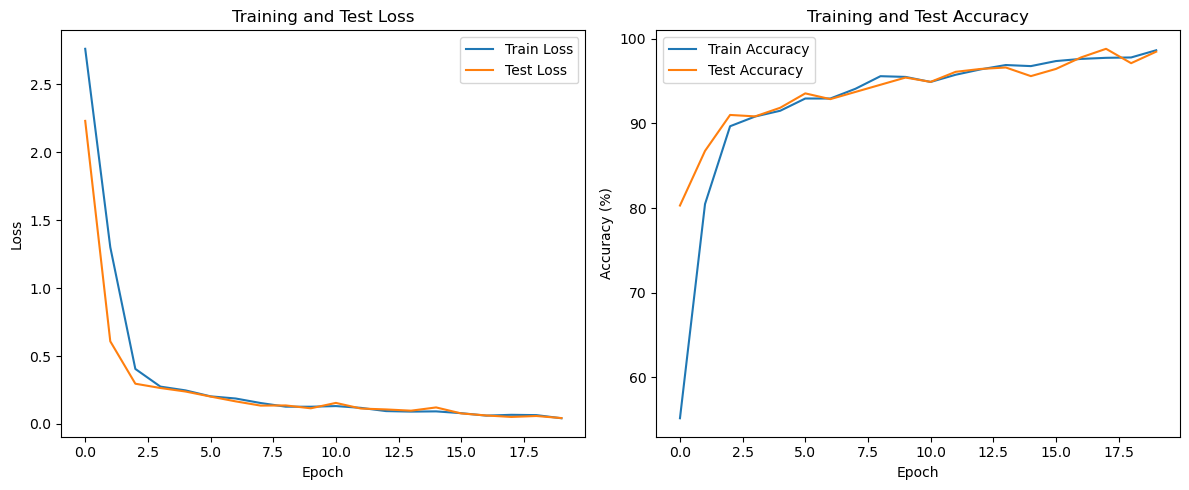

模型已保存到: lstm_predictor.pth


NameError: name 'hot_keys' is not defined

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import json
from collections import Counter

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# 参数设置
sequence_length = 60  # 用于预测的历史序列长度
batch_size = 128      # 批处理大小
num_epochs = 20       # 训练轮数
learning_rate = 0.001 # 学习率
num_devices = 20      # 设备数量
top_k = 100000           # 每个设备维护的热键数量

# 数据加载和预处理函数
def load_and_preprocess_data(file_path):
    """
    加载和预处理访问日志数据
    """
    print("加载数据...")
    df = pd.read_csv(file_path)
    print(f"数据形状: {df.shape}")
    
    # 确保时间戳是整数
    df['timestamp'] = df['timestamp'].astype(int)
    
    # 聚合每秒的访问计数
    print("聚合访问计数...")
    agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
    
    # 确保所有时间戳都有记录
    max_time = df['timestamp'].max()
    agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
    
    # 确保所有设备都有列
    for device_id in range(1, num_devices + 1):
        if device_id not in agg_df.columns:
            agg_df[device_id] = 0
    
    # 按设备ID排序列
    agg_df = agg_df[sorted(agg_df.columns)]
    agg_df.columns = [f'count_dev{i}' for i in range(1, num_devices + 1)]
    
    return agg_df, df

# 分析热键函数
def analyze_hot_keys(df, top_k=100):
    """
    分析日志并提取每个设备的热键
    
    参数:
    df: 原始数据DataFrame
    top_k: 每个设备提取的热键数量
    
    返回:
    每个设备的热键字典
    """
    device_hot_keys = {}
    
    # 获取所有设备ID
    device_ids = df["device_id"].unique()
    
    for device_id in device_ids:
        device_logs = df[df["device_id"] == device_id]
        key_counts = Counter(device_logs["key"])
        
        # 获取前top_k个最常访问的键
        hot_keys = [int(key) for key, count in key_counts.most_common(top_k)]
        device_hot_keys[int(device_id)] = hot_keys
    
    return device_hot_keys

# 保存热键信息
def save_hot_keys(device_hot_keys, filename="hot_keys.json"):
    """保存热键信息到JSON文件"""
    # 确保所有键都是基本Python类型
    serializable_hot_keys = {}
    for device_id, keys in device_hot_keys.items():
        serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
    
    with open(filename, 'w') as f:
        json.dump(serializable_hot_keys, f, indent=4)
    print(f"热键信息已保存到: {filename}")
    return filename

# 创建序列数据集
def create_sequences(data, seq_length):
    """
    创建用于LSTM训练的序列数据
    """
    xs, ys = [], []
    
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

# 训练函数
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    """
    训练模型
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    print("开始训练...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs} '
                      f'Loss: {loss.item():.6f}')
        
        train_accuracy = 100. * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
    
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        
        test_accuracy = 100. * test_correct / test_total
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
    
        scheduler.step(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    end_time = time.time()
    print(f'训练完成! 总耗时: {(end_time - start_time):.2f} s')
    
    return train_losses, test_losses, train_accuracies, test_accuracies


def main():
    log_file = '/home/ming/桌面/PLIN-N /PLIN-N/data/workload_log.csv'
    agg_df, original_df = load_and_preprocess_data(log_file)
    

    # hot_keys = analyze_hot_keys(original_df, top_k=top_k)
    

    # hot_keys_file = save_hot_keys(hot_keys, "hot_keys.json")
    

    # for device_id, keys in hot_keys.items():
    #     print(f"设备 {device_id} 的热键数量: {len(keys)}")
    
 
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(agg_df.values)
    
  
    X, y = create_sequences(scaled_data, sequence_length)
    y_labels = np.argmax(agg_df.values[sequence_length:], axis=1)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y_labels)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    print(f"训练样本数: {len(train_dataset)}")
    print(f"测试样本数: {len(test_dataset)}")
    
    input_size = num_devices  # 10个设备的访问计数
    hidden_size = 128
    num_layers = 2
    num_classes = num_devices  
    
    model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数总数: {total_params:,}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs
    )
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Test Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    model_path = 'lstm_predictor.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'num_classes': num_classes,
        'sequence_length': sequence_length
    }, model_path)
    
    print(f"模型已保存到: {model_path}")
    
    return model, hot_keys, scaler


if __name__ == "__main__":
    main()

### 增加网络通信

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import socket
import threading
import time
from collections import Counter, defaultdict
import select
import os
import re
import warnings
import json
from typing import List, Tuple, Dict, Any, Optional
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

class DeviceAccessDataset(Dataset):
    """Dataset for device access prediction"""
    
    def __init__(self, sequences, targets, sequence_length, num_devices):
        self.sequences = sequences
        self.targets = targets
        self.sequence_length = sequence_length
        self.num_devices = num_devices
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        target = self.targets[idx]
        
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.long)

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

class DeviceAccessPredictor:
    """Main class for device access prediction with communication capabilities"""
    
    def __init__(self, sequence_length=60, num_devices=20, top_k_hot_keys=100000):
        self.sequence_length = sequence_length
        self.num_devices = num_devices
        self.top_k_hot_keys = top_k_hot_keys
        self.model = None
        self.scaler = StandardScaler()
        self.device_hot_keys = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # For data statistics
        self.stats = {}
        
        # Communication setup
        self.sock = None
        self.conn = None
        self.addr = None
        self.running = False
        
        # Log file path
        self.log_file = "/home/ming/桌面/PLIN-N /PLIN-N/data/workload_log.csv"
        
    def setup_communication(self, host='127.0.0.1', port=60001):
        """Set up socket communication with C++"""
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.sock.bind((host, port))
        self.sock.listen(1)
        print(f"Listening for C++ connection on {host}:{port}")
        
        self.conn, self.addr = self.sock.accept()
        print(f"Connected to C++ at {self.addr}")
        
    def listen_for_messages(self):
        """Listen for messages from C++"""
        self.running = True
        
        while self.running:
            try:
                # Check if data is available
                ready = select.select([self.conn], [], [], 0.1)
                if ready[0]:
                    data = self.conn.recv(1024).decode('utf-8')
                    
                    if not data:
                        continue
                        
                    if data.startswith("INDEX:"):
                        # Parse index range
                        parts = data.split(":")
                        if len(parts) >= 3:
                            start_idx = int(parts[1])
                            end_idx = int(parts[2])
                            
                            # Process new data
                            self.train_and_predict(start_idx, end_idx)
                        
            except Exception as e:
                print(f"Error in communication: {e}")
                time.sleep(1)
                
    def analyze_hot_keys(self, df, top_k=100):
        """
        分析日志并提取每个设备的热键
        
        参数:
        df: 原始数据DataFrame
        top_k: 每个设备提取的热键数量
        
        返回:
        每个设备的热键字典
        """
        device_hot_keys = {}
        
        # 获取所有设备ID
        device_ids = df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = df[df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
            
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(top_k)]
            device_hot_keys[int(device_id)] = hot_keys
        
        return device_hot_keys
    
    def save_hot_keys(self, device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        # 确保所有键都是基本Python类型
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
        
        with open(filename, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filename}")
        return filename
    
    def load_and_preprocess_data(self):
        """
        加载和预处理访问日志数据
        """
        print("加载数据...")
        df = pd.read_csv(self.log_file)
        print(f"数据形状: {df.shape}")
        
        df['timestamp'] = df['timestamp'].astype(int)
        print("聚合访问计数...")
        agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
        
        max_time = df['timestamp'].max()
        agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
        

        for device_id in range(1, num_devices + 1):
            if device_id not in agg_df.columns:
                agg_df[device_id] = 0
        
        agg_df = agg_df[sorted(agg_df.columns)]
        agg_df.columns = [f'count_dev{i}' for i in range(1, num_devices + 1)]
        
        return agg_df, df

    # 分析热键函数
    def analyze_hot_keys(df, top_k=100):
        """
        分析日志并提取每个设备的热键
        
        参数:
        df: 原始数据DataFrame
        top_k: 每个设备提取的热键数量
        
        返回:
        每个设备的热键字典
        """
        device_hot_keys = {}
        
        # 获取所有设备ID
        device_ids = df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = df[df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
            
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(top_k)]
            device_hot_keys[int(device_id)] = hot_keys
        
        return device_hot_keys
    
    def save_hot_keys(device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        # 确保所有键都是基本Python类型
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
        
        with open(filename, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filename}")
        return filename
    
    def create_sequences(data, seq_length):
        """
        创建用于LSTM训练的序列数据
        """
        xs, ys = [], []
        
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
            
        return np.array(xs), np.array(ys)
        
    def train_and_predict(self, start_idx, end_idx):
        """Process new data from the log file"""
        print(f"Processing new data from index {start_idx} to {end_idx}")
        agg_df, original_df = load_and_preprocess_data(start_idx,end_idx)
        # hot_keys = analyze_hot_keys(original_df, top_k=top_k)
        # hot_keys_file = save_hot_keys(hot_keys, "hot_keys.json")
        # for device_id, keys in hot_keys.items():
        # print(f"设备 {device_id} 的热键数量: {len(keys)}")
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(agg_df.values)

        # 读取新数据
        try:
            df = pd.read_csv(self.log_file)
            if end_idx > len(df):
                end_idx = len(df)
            if start_idx < 0:
                start_idx = 0
                
            new_df = df.iloc[start_idx:end_idx]
            
            if len(new_df) == 0:
                print("No new data to process")
                return
                
            X, y, agg_df = self.preprocess_data(new_df)
            
            print("IIDSFFFFFFFFFFFFFF")
            if self.model is None:
                print("Training initial model...")
                train_loader, test_loader = self.create_data_loaders(X, y)
                self.train_model(train_loader, test_loader, epochs=15)
                self.evaluate_model(test_loader)
                self.save_model('initial_device_model.pth')
            else:
                print("Updating model with new data...")
                # 这里可以添加模型更新逻辑
                
            # 预测下一个设备
            recent_sequence = self.get_recent_sequence()
            print(f"Recent sequence available for prediction: {len(recent_sequence)}")
            
            if len(recent_sequence) >= self.sequence_length:
                predicted_device = self.predict_next_device(recent_sequence)
                hot_keys = self.device_hot_keys.get(predicted_device, [])
                hot_keys_str = ",".join(map(str, hot_keys[:10000]))  # 只发送前100个热键
                
                # message = f"DEVICE:{predicted_device}:HOT_KEYS:{hot_keys_str}END"
                message = f"HOT_KEYS:{hot_keys_str}END"
                try:
                    self.conn.send(message.encode('utf-8'))
                    print(f"Sent prediction for device {predicted_device}")
                except Exception as e:
                    print(f"Error sending prediction: {e}")
       
        except Exception as e:
            print(f"Error processing new data: {e}")


    
    def train_model(self, train_loader, test_loader, epochs=20, lr=0.001, patience=5):
        """Train the LSTM model"""
        print(f"\nInitializing LSTM model with input size: {self.num_devices}")
        start_time = time.time()
        
        input_size = self.num_devices
        hidden_size = 128
        num_layers = 2
        num_classes = self.num_devices
        
        self.model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(self.device)
        
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience//2, verbose=True
        )
        
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []
        best_test_loss = float('inf')
        patience_counter = 0
        
        print(f"\nStarting training for {epochs} epochs...")
        
        for epoch in range(epochs):
            epoch_start = time.time()
            
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch+1}/{epochs} Loss: {loss.item():.6f}')
            
            train_accuracy = 100. * train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)
        
            self.model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    output = self.model(data)
                    test_loss += criterion(output, target).item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_accuracy = 100. * test_correct / test_total
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)
            # scheduler the learning rate
            scheduler.step(avg_test_loss)
            
            # early stop
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                patience_counter = 0
                # 保存最佳模型
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'scaler': self.scaler,
                    'input_size': input_size,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'num_classes': num_classes,
                    'sequence_length': self.sequence_length,
                    'device_hot_keys': self.device_hot_keys
                }, 'best_device_model.pth')
            else:
                patience_counter += 1
        
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nEpoch [{epoch+1}/{epochs}] - {time.time()-epoch_start:.2f}s")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
            print(f"  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, LR: {current_lr:.6f}")
            
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        # 加载最佳模型
        if os.path.exists('best_device_model.pth'):
            checkpoint = torch.load('best_device_model.pth', map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.scaler = checkpoint['scaler']
            self.device_hot_keys = checkpoint.get('device_hot_keys', {})
            print("Loaded best model weights")
        
        print(f"\nTraining completed in {time.time()-start_time:.2f} seconds")
        return train_losses, test_losses, train_accuracies, test_accuracies
    
    # def evaluate_model(self, test_loader):
    #     """Evaluate the model"""
    #     print("\nEvaluating model...")
    #     start_time = time.time()
        
    #     self.model.eval()
    #     test_loss = 0.0
    #     test_correct = 0
    #     test_total = 0
        
    #     criterion = nn.CrossEntropyLoss()
        
    #     with torch.no_grad():
    #         for data, target in test_loader:
    #             data, target = data.to(self.device), target.to(self.device)
    #             output = self.model(data)
    #             test_loss += criterion(output, target).item()
    #             _, predicted = torch.max(output.data, 1)
    #             test_total += target.size(0)
    #             test_correct += (predicted == target).sum().item()
        
    #     test_accuracy = 100. * test_correct / test_total
    #     avg_test_loss = test_loss / len(test_loader)
        
    #     print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    #     print(f"Evaluation completed in {time.time()-start_time:.2f} seconds")
        
    #     return avg_test_loss, test_accuracy
    
    # def predict_next_device(self, recent_sequence):
    #     """Predict the next device to be accessed"""
    #     if len(recent_sequence) < self.sequence_length:
    #         raise ValueError(f"Need at least {self.sequence_length} recent sequences, got {len(recent_sequence)}")
        
    #     input_sequence = recent_sequence[-self.sequence_length:]
    #     input_tensor = torch.tensor([input_sequence], dtype=torch.float32).to(self.device)
        
    #     self.model.eval()
    #     with torch.no_grad():
    #         predictions = self.model(input_tensor)
    #         predicted_device = torch.argmax(predictions, dim=1).item() + 1  # 设备ID从1开始
        
    #     return predicted_device
    
    # def get_recent_sequence(self):
    #     """Get the most recent sequence from the log file"""
    #     try:
    #         df = pd.read_csv(self.log_file)
            
    #         # 确保时间戳是整数
    #         df['timestamp'] = df['timestamp'].astype(int)
            
    #         # 聚合每秒的访问计数
    #         agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
            
    #         # 确保所有设备都有列
    #         for device_id in range(1, self.num_devices + 1):
    #             if device_id not in agg_df.columns:
    #                 agg_df[device_id] = 0
            
    #         # 按设备ID排序列
    #         agg_df = agg_df[sorted(agg_df.columns)]
            
    #         # 标准化数据
    #         scaled_data = self.scaler.transform(agg_df.values)
            
    #         # 获取最近的序列
    #         if len(scaled_data) >= self.sequence_length:
    #             return scaled_data[-self.sequence_length:]
    #         else:
    #             return scaled_data
                
    #     except Exception as e:
    #         print(f"Error getting recent sequence: {e}")
    #         return []
        
    # def load_and_preprocess_data(self):
    #     """
    #     加载和预处理访问日志数据
    #     """
    #     print("加载数据...")
    #     df = pd.read_csv(self.log_file)
    #     print(f"数据形状: {df.shape}")
        
    #     df['timestamp'] = df['timestamp'].astype(int)
    #     print("聚合访问计数...")
    #     agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
        
    #     max_time = df['timestamp'].max()
    #     agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
        

    #     for device_id in range(1, num_devices + 1):
    #         if device_id not in agg_df.columns:
    #             agg_df[device_id] = 0
        
    #     agg_df = agg_df[sorted(agg_df.columns)]
    #     agg_df.columns = [f'count_dev{i}' for i in range(1, num_devices + 1)]
        
    #     return agg_df, df

    # # 分析热键函数
    # def analyze_hot_keys(df, top_k=100):
    #     """
    #     分析日志并提取每个设备的热键
        
    #     参数:
    #     df: 原始数据DataFrame
    #     top_k: 每个设备提取的热键数量
        
    #     返回:
    #     每个设备的热键字典
    #     """
    #     device_hot_keys = {}
        
    #     # 获取所有设备ID
    #     device_ids = df["device_id"].unique()
        
    #     for device_id in device_ids:
    #         device_logs = df[df["device_id"] == device_id]
    #         key_counts = Counter(device_logs["key"])
            
    #         # 获取前top_k个最常访问的键
    #         hot_keys = [int(key) for key, count in key_counts.most_common(top_k)]
    #         device_hot_keys[int(device_id)] = hot_keys
        
    #     return device_hot_keys
    
    # def save_hot_keys(device_hot_keys, filename="hot_keys.json"):
    #     """保存热键信息到JSON文件"""
    #     # 确保所有键都是基本Python类型
    #     serializable_hot_keys = {}
    #     for device_id, keys in device_hot_keys.items():
    #         serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
        
    #     with open(filename, 'w') as f:
    #         json.dump(serializable_hot_keys, f, indent=4)
    #     print(f"热键信息已保存到: {filename}")
    #     return filename
    
    # def create_sequences(data, seq_length):
    #     """
    #     创建用于LSTM训练的序列数据
    #     """
    #     xs, ys = [], []
        
    #     for i in range(len(data) - seq_length):
    #         x = data[i:i+seq_length]
    #         y = data[i+seq_length]
    #         xs.append(x)
    #         ys.append(y)
            
    #     return np.array(xs), np.array(ys)
        
    # def train_and_predict(self, start_idx, end_idx):
    #     """Process new data from the log file"""
    #     print(f"Processing new data from index {start_idx} to {end_idx}")
    #     agg_df, original_df = load_and_preprocess_data(start_idx,end_idx)
    #     # hot_keys = analyze_hot_keys(original_df, top_k=top_k)
    #     # hot_keys_file = save_hot_keys(hot_keys, "hot_keys.json")
    #     # for device_id, keys in hot_keys.items():
    #     # print(f"设备 {device_id} 的热键数量: {len(keys)}")
    #     scaler = StandardScaler()
    #     scaled_data = scaler.fit_transform(agg_df.values)

    #     # 读取新数据
    #     try:
    #         df = pd.read_csv(self.log_file)
    #         if end_idx > len(df):
    #             end_idx = len(df)
    #         if start_idx < 0:
    #             start_idx = 0
                
    #         new_df = df.iloc[start_idx:end_idx]
            
    #         if len(new_df) == 0:
    #             print("No new data to process")
    #             return
                
    #         X, y, agg_df = self.preprocess_data(new_df)
            
    #         print("IIDSFFFFFFFFFFFFFF")
    #         if self.model is None:
    #             print("Training initial model...")
    #             train_loader, test_loader = self.create_data_loaders(X, y)
    #             self.train_model(train_loader, test_loader, epochs=15)
    #             self.evaluate_model(test_loader)
    #             self.save_model('initial_device_model.pth')
    #         else:
    #             print("Updating model with new data...")
    #             # 这里可以添加模型更新逻辑
                
    #         # 预测下一个设备
    #         recent_sequence = self.get_recent_sequence()
    #         print(f"Recent sequence available for prediction: {len(recent_sequence)}")
            
    #         if len(recent_sequence) >= self.sequence_length:
    #             predicted_device = self.predict_next_device(recent_sequence)
    #             hot_keys = self.device_hot_keys.get(predicted_device, [])
    #             hot_keys_str = ",".join(map(str, hot_keys[:10000]))  # 只发送前100个热键
                
    #             # message = f"DEVICE:{predicted_device}:HOT_KEYS:{hot_keys_str}END"
    #             message = f"HOT_KEYS:{hot_keys_str}END"
    #             try:
    #                 self.conn.send(message.encode('utf-8'))
    #                 print(f"Sent prediction for device {predicted_device}")
    #             except Exception as e:
    #                 print(f"Error sending prediction: {e}")
       
    #     except Exception as e:
    #         print(f"Error processing new data: {e}")
    
    def save_model(self, filepath: str):
        """Save the trained model and metadata"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'scaler': self.scaler,
            'input_size': self.num_devices,
            'hidden_size': 128,
            'num_layers': 2,
            'num_classes': self.num_devices,
            'sequence_length': self.sequence_length,
            'device_hot_keys': self.device_hot_keys
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load a trained model and metadata"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        input_size = checkpoint['input_size']
        hidden_size = checkpoint['hidden_size']
        num_layers = checkpoint['num_layers']
        num_classes = checkpoint['num_classes']
        
        self.model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.scaler = checkpoint['scaler']
        self.device_hot_keys = checkpoint.get('device_hot_keys', {})
        
        print(f"Model loaded from {filepath}")
    
    def stop(self):
        """Stop the communication thread"""
        self.running = False
        if self.conn:
            self.conn.close()
        if self.sock:
            self.sock.close()

def main():
    # Create predictor instance
    predictor = DeviceAccessPredictor(
        sequence_length=60,
        num_devices=20,
        top_k_hot_keys=100000
    )
    
    # only for test
    predictor.train_and_predict(0, 304993)
if __name__ == "__main__":
    main()

Using device: cuda
Processing new data from index 0 to 304993


NameError: name 'load_and_preprocess_data' is not defined